# Data Research Engineer Assignment Task One

This notebook contains work on the two take home tasks for the Data Research Engineer role.

### Task One Description

The first task concerns the dataset `data_task_1.csv` which has six columns, `input_1`, `input_2`, `input_3`, `input_4`, `input_5` and `Output`. There are 10,000 rows of numeric data. The goal is to investigate the data and note down what I can about the dataset.

It is stated that `Output` can be predicted accurately based on a simple mathematical formula. So I'll aim to find the formula as well, although even if I don't find it, the goal is to communicate the analysis and thought process I use to understand the data.

### The code

In [44]:
import jax
import jax.numpy as jnp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dataset_1 = pd.read_csv('data_task_1.csv')
dataset_1

,Input1,Input2,Input3,Input4,Input5,Output
0,1,41.071703,60.223923,0,8.995483,135.222245
1,0,23.481957,35.690760,1,2.981027,45.005410
2,0,38.387505,3.650336,0,7.989415,120.131228
3,0,32.127736,4.533149,1,2.879249,43.478741
4,1,21.169601,35.051853,0,2.433408,36.791118
...,...,...,...,...,...,...
9995,0,26.780547,32.776924,1,1.675854,25.427812
9996,1,40.529935,85.323995,0,7.912701,118.980517
9997,1,27.865801,67.679998,0,4.064771,61.261570
9998,0,50.406496,48.010130,0,9.949178,149.527677


Looks like we have 10,000 rows as promised, plus `Input1` and `Input4` appear to be binary valued. I can check this next.

In [3]:
try:
    dataset_1.Input1
except AttributeError as e:
    print(e)

'DataFrame' object has no attribute 'Input1'


Ha - this is weird. Lets list the columns:

In [4]:
dataset_1.columns

Index(['Input1 ', ' Input2 ', ' Input3 ', ' Input4 ', ' Input5 ', ' Output'], dtype='object')

Ok, turns out the column names are dirty. So time to clean them.

In [5]:
dataset_1.columns = [c.strip() for c in dataset_1.columns]

In [6]:
dataset_1.Input1

0       1
1       0
2       0
3       0
4       1
       ..
9995    0
9996    1
9997    1
9998    0
9999    1
Name: Input1, Length: 10000, dtype: int64

There! Now we'll try summarising the binary columns again:

In [7]:
dataset_1.Input1.value_counts()

0    5060
1    4940
Name: Input1, dtype: int64

In [8]:
dataset_1.Input4.value_counts()

1    5035
0    4965
Name: Input4, dtype: int64

Great - this proves they're both binary. They're also very split down the middle it appears, in terms of the counts.

Now lets take a look at a high level summary of the data.

In [9]:
dataset_1.describe()

,Input1,Input2,Input3,Input4,Input5,Output
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,0.494000,34.192252,50.096821,0.503500,4.872678,4.846025e+03
std,0.499989,10.958632,28.950458,0.500013,2.955536,1.766151e+05
min,0.000000,-1.000000,0.000629,0.000000,-1.000000,3.284370e-01
25%,0.000000,27.049083,25.258501,0.000000,2.396622,4.955440e+01
50%,0.000000,34.584661,49.988743,1.000000,4.886194,9.882422e+01
75%,1.000000,42.104922,75.335844,1.000000,7.383571,1.500271e+02
max,1.000000,66.836973,99.986851,1.000000,9.998175,8.761760e+06


Trying to note anything suspicious in here. I see `-1` values in columns `Input2` and `Input5`. These could be markers for missingness, lets investigate further:

In [10]:
# Count the values in Input2 which are less than 0
dataset_1.loc[dataset_1.Input2 < 0, 'Input2'].value_counts()

-1.0    192
Name: Input2, dtype: int64

In [11]:
# Count the values in Input5 which are less than 0
dataset_1.loc[dataset_1.Input5 < 0, 'Input2'].value_counts()

-1.0    192
Name: Input2, dtype: int64

Since both columns have the same count of missingness, I'll check if they're also missing at the same time.

In [12]:
both_missing = (dataset_1.Input5 < 0) | (dataset_1.Input2 < 0)
dataset_1.loc[both_missing, :]

,Input1,Input2,Input3,Input4,Input5,Output
30,0,-1.0,27.572598,1,-1.0,53.820299
56,1,-1.0,76.184729,0,-1.0,26.430460
117,0,-1.0,24.080971,0,-1.0,26.108308
178,0,-1.0,22.404201,0,-1.0,148.782003
401,1,-1.0,4.666711,1,-1.0,1529.756648
...,...,...,...,...,...,...
9588,0,-1.0,64.995363,0,-1.0,112.309408
9604,0,-1.0,3.587487,1,-1.0,146.941468
9621,0,-1.0,28.789926,0,-1.0,146.667796
9764,1,-1.0,49.180003,1,-1.0,1645.640501


It looks like they are missing together, but I can check this for certain using a group by:

In [13]:
dataset_1.loc[both_missing, ['Input2', 'Input5']].groupby(['Input2', 'Input5']).size()

Input2  Input5
-1.0    -1.0      192
dtype: int64

This confirms that indeed they are both missing at the same time. Time to take a second look at the summary table just to see if I get any other funny vibes.

In [14]:
dataset_1.describe()

,Input1,Input2,Input3,Input4,Input5,Output
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,0.494000,34.192252,50.096821,0.503500,4.872678,4.846025e+03
std,0.499989,10.958632,28.950458,0.500013,2.955536,1.766151e+05
min,0.000000,-1.000000,0.000629,0.000000,-1.000000,3.284370e-01
25%,0.000000,27.049083,25.258501,0.000000,2.396622,4.955440e+01
50%,0.000000,34.584661,49.988743,1.000000,4.886194,9.882422e+01
75%,1.000000,42.104922,75.335844,1.000000,7.383571,1.500271e+02
max,1.000000,66.836973,99.986851,1.000000,9.998175,8.761760e+06


Having taken a second look, everything else looks fairly normal. I can see that the range for `Output` is a lot wider than for the other variables, which could mean there are exponentials at play somewhere.

## Visualisation

In [15]:
import seaborn as sns

Now I want to try visualising the data, so I'll start with a pairplot. I downsample the data to 1,000 rows because otherwise it would take a while to plot and probably the scatterplots would end up cluttered anyway.

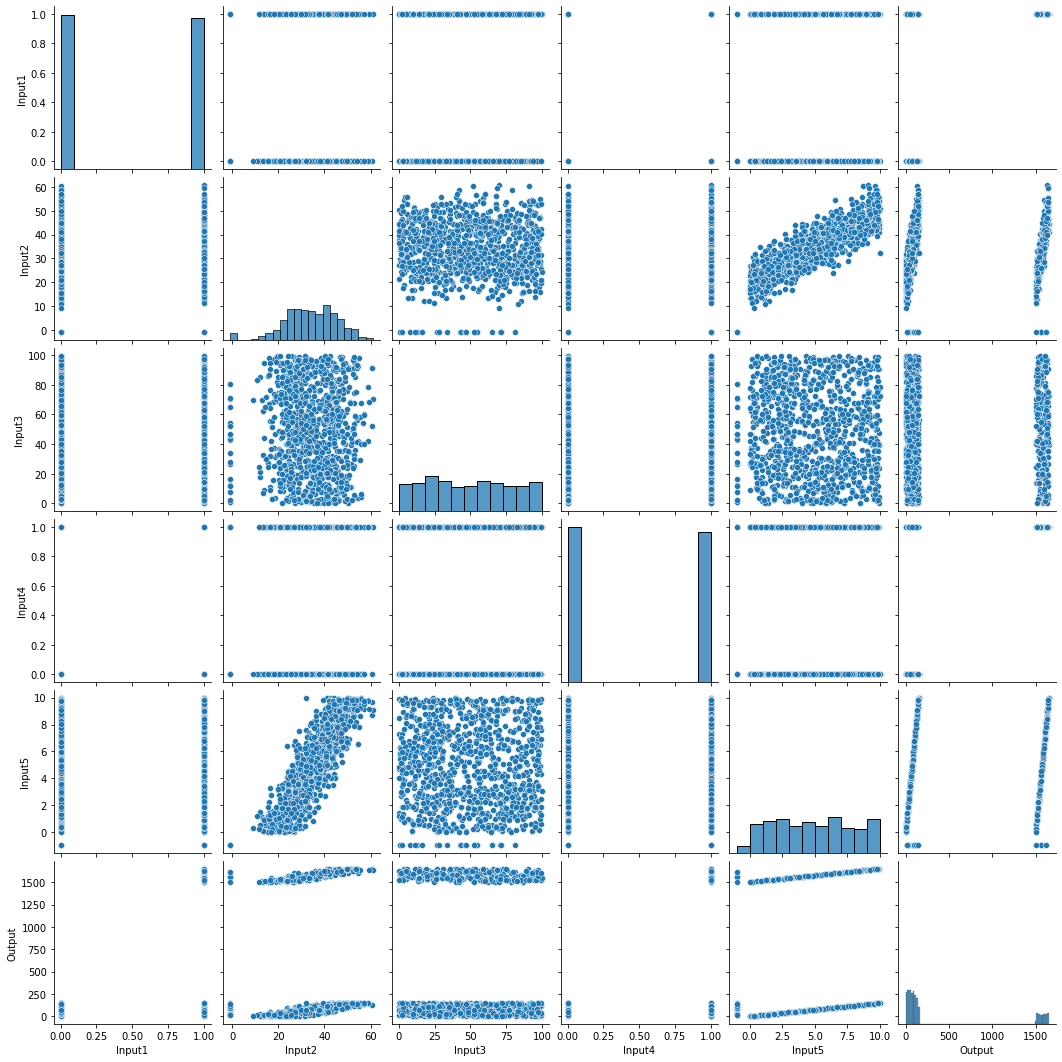

In [17]:
sns.pairplot(dataset_1.sample(1000))

### Some thoughts
- Taking a look at `Input2` vs `Input5`, it looks like a logistic function might be at play.
- I can see the missing values in `Input2` and `Input5`, they don't seem to matter much so I can try again with those rows removed.

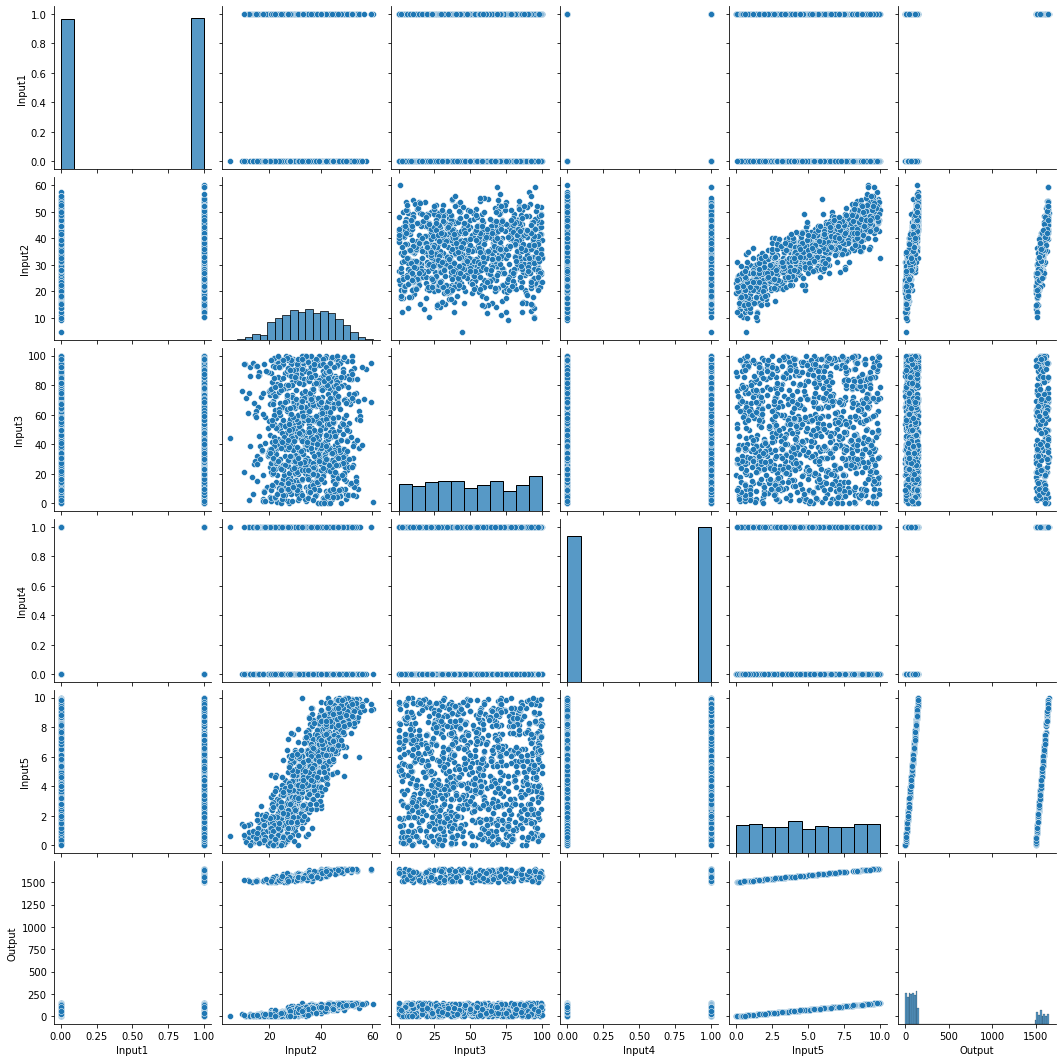

In [20]:
sns.pairplot(dataset_1.loc[(dataset_1.Input2 != -1) & (dataset_1.Input5 != -1), :].sample(1000))

### Some more thoughts

Now, taking a look at this plot, I can consider the densities along the diagonal.

- `Input1` and `Input4` are binary valued and might be independent but this is not clear from the plot.
- `Input2` could be normally distributed.
- `Input3` and `Input5` look uniformly distributed with support [0, 100] and [0,10] respectively.
- Additionally, `Input3` and `Input5` are independent

Now I want to take a second look at the `Output` column, which seems the weirdest, which I guess makes sense.

<AxesSubplot:>

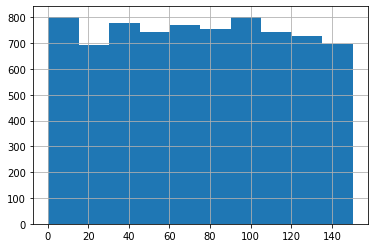

In [38]:
# Plot the bottom end of `Output`
dataset_1.loc[dataset_1.Output < 800, 'Output'].hist()

<AxesSubplot:>

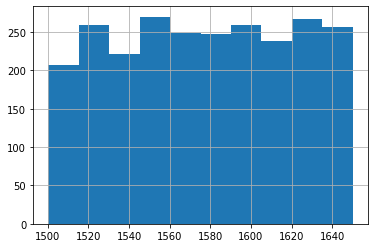

In [39]:
# Plot the high end of `Output`
dataset_1.loc[dataset_1.Output >= 800, 'Output'].hist()

Ah - there are outliers in the Output column that I missed in the seaborn plot because of the sampling.

Well, in the pairplot I can see that the usual range for `Output` goes up to just past 1500, so I can select all the points beyond 2000 to find those outliers.

In [36]:
dataset_1.loc[dataset_1.Output > 2000, :]

,Input1,Input2,Input3,Input4,Input5,Output
3466,1,33.027161,92.256311,0,7.808586,8.362205e+06
3754,1,40.852968,51.275720,0,3.847743,3.537193e+06
4756,1,34.856361,15.763010,1,6.509479,8.296574e+06
4900,1,30.359210,34.379378,1,1.261131,3.281209e+06
5318,1,47.005163,48.702689,0,7.729303,7.330105e+06
7144,1,22.932639,65.358244,1,1.643869,4.426035e+06
8759,0,-1.000000,21.078083,1,-1.000000,8.761760e+06


I'm going to assume this is not normal behaviour and drop these rows from the table.

In [40]:
dataset_1 = dataset_1.loc[dataset_1.Output < 2000, :]

Now I can attempt to replot the histogram of the high values of `Output` again.

<AxesSubplot:>

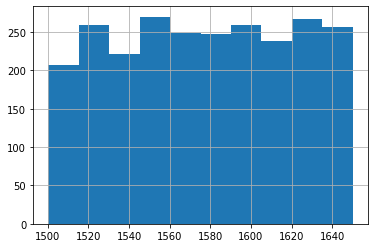

In [41]:
# Plot the high end of `Output`
dataset_1.loc[dataset_1.Output >= 800, 'Output'].hist()

## Reconstructing the relationship

To reconstruct the relationship, I'll create some variables and play with them for a bit.

In [43]:
dataset_1.describe()

,Input1,Input2,Input3,Input4,Input5,Output
count,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000
mean,0.493746,34.195385,50.099009,0.503452,4.873309,446.829285
std,0.499986,10.955208,28.953198,0.500013,2.955242,650.070362
min,0.000000,-1.000000,0.000629,0.000000,-1.000000,0.328437
25%,0.000000,27.051396,25.258814,0.000000,2.397258,49.538646
50%,0.000000,34.585732,49.993264,1.000000,4.886378,98.754922
75%,1.000000,42.104931,75.350030,1.000000,7.383189,149.986599
max,1.000000,66.836973,99.986851,1.000000,9.998175,1650.109830


### How I would wrap it up

Since I'm limited for time, I'll just explain that the plan from here is simply to try fiddling with some distributions to see if I can replicate the relationships that I see in the pairplot.

Since I have a decent picture of which variables are dependent on the other, I simply have to encode that into the `relationship` function.

Then when I'm done I could train a model using my inferred relationship as a prior which would give me parameter estimates for the values that I may have guessed.

In [ ]:
def relationship(I1, I2, I3, I4, I5):
    jax.nn.sigmoid(I2 * I5) # I expect to use this somewhere
    return I1 + I2 + I3 + I4 + I5

def model(N, t=None, D=None):
    """
    An attempt at modelling the data.
    """
    I1 = numpyro.sample('I1', dist.Bernoulli(0.5))
    I2 = numpyro.sample('I2', dist.Normal(35, 11))
    I3 = numpyro.sample('I3', dist.Uniform(0, 100))
    I4 = numpyro.sample('I4', dist.Bernoulli(0.5))
    I5 = numpyro.sample('I5', dist.Uniform(0, 10))
    Output = numpyro.deterministic('Output', relationship(I1=I1, I2=I2, I3=I3, I4=I4, I5=I5))
    
    with numpyro.plate('data', N):
        numpyro.sample('obs', dist.Normal(rate_t), obs=D) # observe disaster counts from a poisson distribution
    return 